In [13]:
# 📦 라이브러리 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# ✅ 한글 설정 및 마이너스 깨짐 방지
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 📂 데이터 불러오기
train = pd.read_csv('train.csv').drop(columns=['ID'])
test = pd.read_csv('test.csv').drop(columns=['ID'])
sample_submission = pd.read_csv('sample_submission.csv')

# 🔧 범위값 처리 함수
def convert_range_to_float(value):
    if isinstance(value, str) and '-' in value:
        try:
            low, high = map(float, value.split('-'))
            return (low + high) / 2
        except:
            return np.nan
    try:
        return float(value)
    except:
        return np.nan

# 🔧 범주형 인코딩
def encode_categoricals(df, cols):
    df = df.copy()
    for col in cols:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    return df

# 🔧 결측치 처리 함수
def fill_missing_values(df, is_train=True):
    df = df.copy()

    # 범위 문자열 → 평균 숫자 처리
    for col in ['연매출(억원)', '총 투자금(억원)', '기업가치(백억원)']:
        df[col] = df[col].apply(convert_range_to_float)

    # 분야 결측 및 인코딩
    if '분야' in df.columns:
        df['분야'] = df['분야'].fillna('Unknown')
        df['분야'] = LabelEncoder().fit_transform(df['분야'])

    # 국가, 투자단계 인코딩
    df = encode_categoricals(df, ['국가', '투자단계'])

    # ✅ 결측 플래그 추가 함수
    def add_missing_flag(column):
        flag_col = f'{column}_결측'
        df[flag_col] = df[column].isnull().astype(int)

    # ✅ 피처셋 생성 함수
    def get_features(base):
        return base + (['성공확률'] if is_train else [])

    # 1. 직원 수
    if '직원 수' in df.columns:
        add_missing_flag('직원 수')
        features = get_features(['설립연도', '국가', '투자단계', '연매출(억원)', '총 투자금(억원)', 'SNS 팔로워 수(백만명)'])
        complete = df[df['직원 수'].notnull()]
        missing = df[df['직원 수'].isnull()]
        if not complete.empty and not missing.empty:
            model = GradientBoostingRegressor()
            model.fit(complete[features], complete['직원 수'])
            df.loc[df['직원 수'].isnull(), '직원 수'] = model.predict(missing[features])

    # 2. 고객 수
    if '고객수(백만명)' in df.columns:
        add_missing_flag('고객수(백만명)')
        features = get_features(['설립연도', '직원 수', '분야', '연매출(억원)', '총 투자금(억원)', 'SNS 팔로워 수(백만명)'])
        complete = df[df['고객수(백만명)'].notnull()]
        missing = df[df['고객수(백만명)'].isnull()]
        if not complete.empty and not missing.empty:
            model = GradientBoostingRegressor()
            model.fit(complete[features], complete['고객수(백만명)'])
            df.loc[df['고객수(백만명)'].isnull(), '고객수(백만명)'] = model.predict(missing[features])

    # 3. 기업가치
    if '기업가치(백억원)' in df.columns:
        add_missing_flag('기업가치(백억원)')
        features = get_features(['설립연도', '직원 수', '고객수(백만명)', '분야', '연매출(억원)', '총 투자금(억원)', 'SNS 팔로워 수(백만명)'])
        complete = df[df['기업가치(백억원)'].notnull()]
        missing = df[df['기업가치(백억원)'].isnull()]
        if not complete.empty and not missing.empty:
            model = GradientBoostingRegressor()
            model.fit(complete[features], complete['기업가치(백억원)'])
            df.loc[df['기업가치(백억원)'].isnull(), '기업가치(백억원)'] = model.predict(missing[features])

    return df

# 📌 데이터 전처리
train_filled = fill_missing_values(train, is_train=True)
test_filled = fill_missing_values(test, is_train=False)

# 📌 이상치 처리 함수
def process_outliers(train_df, test_df, num_cols, method='flag+clip'):
    train, test = train_df.copy(), test_df.copy()
    for col in num_cols:
        Q1, Q3 = train[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

        if 'flag' in method:
            train[f'{col}_이상치여부'] = ((train[col] < lower) | (train[col] > upper)).astype(int)
            test[f'{col}_이상치여부'] = ((test[col] < lower) | (test[col] > upper)).astype(int)

        if 'clip' in method:
            train[col] = train[col].clip(lower, upper)
            test[col] = test[col].clip(lower, upper)

    return train, test

num_cols = train_filled.select_dtypes(include=np.number).columns.drop('성공확률').tolist()
train_processed, test_processed = process_outliers(train_filled, test_filled, num_cols)



def detect_outliers_summary(df, columns):
    summary = []
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        summary.append({
            '컬럼명': col,
            '이상치 수': len(outliers),
            '전체 대비 비율(%)': round(len(outliers) / len(df) * 100, 2)
        })
    return pd.DataFrame(summary).sort_values(by='이상치 수', ascending=False)

# log 변환 (0보다 큰 값만 변환, log1p는 log(1+x))
num_cols = train_filled.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(num_cols)
log_train = train_filled[num_cols].copy()
for col in num_cols:
    if (log_train[col] > 0).all():  # 음수, 0 있는 컬럼은 제외
        log_train[col] = np.log1p(log_train[col])

def process_outliers_train_test(train_df, test_df, num_cols, method='flag+clip'):
    """
    train 데이터 기준으로 IQR 이상치 탐지 기준을 잡고,
    train/test 모두 동일한 방식으로 이상치 처리하는 함수
    """
    train_processed = train_df.copy()
    test_processed = test_df.copy()
    outlier_bounds = {}

    for col in num_cols:
        Q1 = train_df[col].quantile(0.25)
        Q3 = train_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_bounds[col] = (lower, upper)

        # 이상치 플래그
        if 'flag' in method:
            train_processed[f'{col}_이상치여부'] = ((train_df[col] < lower) | (train_df[col] > upper)).astype(int)
            test_processed[f'{col}_이상치여부'] = ((test_df[col] < lower) | (test_df[col] > upper)).astype(int)

        # 클리핑
        if 'clip' in method:
            train_processed[col] = train_df[col].clip(lower, upper)
            test_processed[col] = test_df[col].clip(lower, upper)

        # 로그 변환
        if 'log' in method:
            if (train_processed[col] >= 0).all() and (test_processed[col] >= 0).all():
                train_processed[col] = np.log1p(train_processed[col])
                test_processed[col] = np.log1p(test_processed[col])
            else:
                print(f"[경고] {col}은 log1p 불가능 (음수 또는 0 포함)")

    return train_processed, test_processed, outlier_bounds

# '성공확률'은 train에만 있으므로 제외
num_cols = train_filled.select_dtypes(include=np.number).columns.tolist()
num_cols = [col for col in num_cols if col != '성공확률']

# 이상치 처리 수행
train_processed, test_processed, bounds = process_outliers_train_test(train_filled, test_filled, num_cols, method='flag+clip')

# 결과 확인: 일부 컬럼에 대해 이상치 여부 플래그 분포 출력
for col in ['연매출(억원)', '고객수(백만명)', 'SNS 팔로워 수(백만명)']:
    flag_col = f'{col}_이상치여부'
    if flag_col in train_processed.columns:
        print(f"▶ {flag_col} - 이상치 개수(train): {train_processed[flag_col].sum()}")

print("✅ train 결측 확인:\n", train_filled.isnull().sum().sort_values(ascending=False))
print("✅ test 결측 확인:\n", test_filled.isnull().sum().sort_values(ascending=False))

['설립연도', '국가', '분야', '투자단계', '직원 수', '고객수(백만명)', '총 투자금(억원)', '연매출(억원)', 'SNS 팔로워 수(백만명)', '기업가치(백억원)', '성공확률', '직원 수_결측', '고객수(백만명)_결측', '기업가치(백억원)_결측']
▶ 연매출(억원)_이상치여부 - 이상치 개수(train): 0
▶ 고객수(백만명)_이상치여부 - 이상치 개수(train): 0
▶ SNS 팔로워 수(백만명)_이상치여부 - 이상치 개수(train): 0
✅ train 결측 확인:
 설립연도              0
국가                0
분야                0
투자단계              0
직원 수              0
인수여부              0
상장여부              0
고객수(백만명)          0
총 투자금(억원)         0
연매출(억원)           0
SNS 팔로워 수(백만명)    0
기업가치(백억원)         0
성공확률              0
직원 수_결측           0
고객수(백만명)_결측       0
기업가치(백억원)_결측      0
dtype: int64
✅ test 결측 확인:
 설립연도              0
국가                0
분야                0
투자단계              0
직원 수              0
인수여부              0
상장여부              0
고객수(백만명)          0
총 투자금(억원)         0
연매출(억원)           0
SNS 팔로워 수(백만명)    0
기업가치(백억원)         0
직원 수_결측           0
고객수(백만명)_결측       0
기업가치(백억원)_결측      0
dtype: int64


In [11]:
# 📌 파생변수 생성
def create_features(df):
    df = df.copy()

    return df

X = train_processed.copy()  # ← 여기서 train_processed에 이상치 플래그가 들어있어야 함
X = create_features(X)      # 파생변수 추가
X_test = test_processed.copy()
X_test = create_features(X_test)
y = train_processed['성공확률']  # 또는 미리 분리한 y 사용

# 📌 필요없는 컬럼 제거
remove_cols = ['직원 수', '연매출(억원)', '설립연도', '총 투자금(억원)', '직원 수_결측', '고객수_결측']
X.drop(columns=[col for col in remove_cols if col in X.columns], inplace=True)
X_test.drop(columns=[col for col in remove_cols if col in X_test.columns], inplace=True)

# ✅ 이진형 인코딩
for col in ['인수여부', '상장여부']:
    for df in [X, X_test]:
        if col in df.columns:
            df[col] = df[col].map({'No': 0, 'Yes': 1})

# '성공확률' 컬럼이 있다면 삭제
if '성공확률' in X.columns:
    X = X.drop(columns=['성공확률'])

# y 결합
X_with_y = X.join(y.rename("성공확률"))  

In [32]:
import featuretools as ft

# 🧹 index 필요
X_with_y = X.copy()
X_with_y["성공확률"] = y
X_with_y.reset_index(drop=True, inplace=True)
X_with_y["index"] = X_with_y.index  # featuretools는 식별자 필수

# ✅ EntitySet 생성
es = ft.EntitySet(id="startup_data")
es = es.add_dataframe(dataframe_name="data", dataframe=X_with_y, index="index")

# ✅ 자동 파생변수 생성
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="data",
    max_depth=2,  # 조합 깊이
    verbose=True
)

# ✅ 성공확률 분리
y_ft = feature_matrix['성공확률']
X_ft = feature_matrix.drop(columns=["성공확률"])


c:\Users\human\.conda\envs\dacon\Lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


Built 24 features
Elapsed: 00:00 | Progress: 100%|██████████


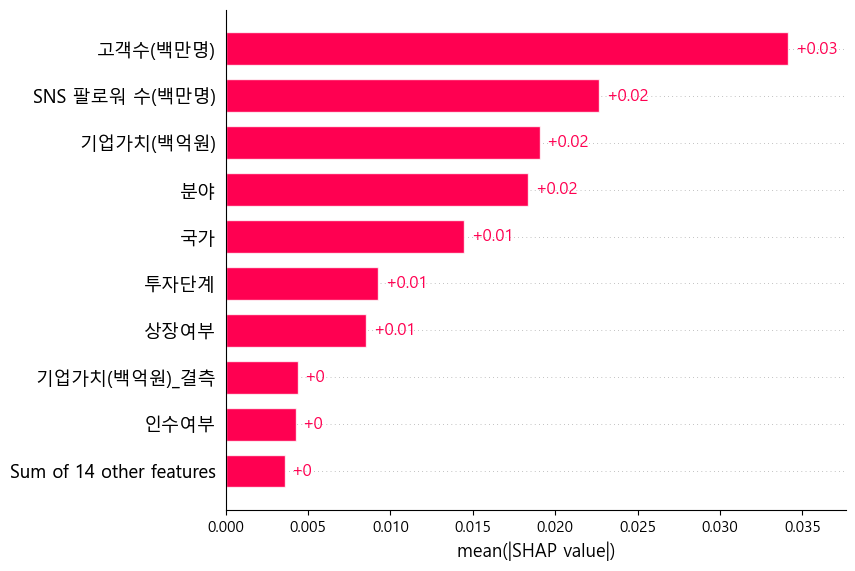

In [35]:
X_ft.isnull().sum().sort_values(ascending=False)
import shap
from xgboost import XGBRegressor


model = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
model.fit(X_ft.fillna(0), y_ft)

explainer = shap.Explainer(model)
shap_values = explainer(X_ft.fillna(0))

shap.plots.bar(shap_values)

In [37]:
# SHAP 중요도 추출
shap_importance = np.abs(shap_values.values).mean(axis=0)

# 임계값 기준으로 중요한 피처만 선택 (예: 평균 SHAP값이 0.01 이상)
important_mask = shap_importance > 0.01

# 중요 피처 이름 리스트
important_features = np.array(X_ft.columns)[important_mask]

# 데이터셋 축소
X_selected = X_ft[important_features]


In [44]:
# X_selected: SHAP으로 선택된 중요 피처만 포함된 train 데이터
# X_test_selected: 동일한 피처만 유지한 test 데이터 (반드시 동일한 열 순서 유지)

X_selected = X_ft[important_features]
#X_test_selected = test_ft[important_features]  # ← test도 같은 방식으로 featuretools → same features

# StratifiedKFold용 binning
bins = np.linspace(0, 1, 6)
y_binned = np.digitize(y, bins)

cv_scores, test_preds = [], []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_selected, y_binned)):
    print(f"Fold {fold+1}")
    X_tr, y_tr = X_selected.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X_selected.iloc[val_idx], y.iloc[val_idx]

    model = XGBRegressor(
        n_estimators=1325,
        learning_rate=0.00375,
        max_depth=15,
        subsample=0.58315,
        colsample_bytree=0.75715,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    print(f"  MAE: {mae:.5f}")

    cv_scores.append(mae)
    #test_preds.append(model.predict(X_test_selected))

print(f"\n📉 중요 피처 기반 평균 MAE: {np.mean(cv_scores):.5f}")


Fold 1
  MAE: 0.20649
Fold 2
  MAE: 0.20318
Fold 3
  MAE: 0.20842
Fold 4


KeyboardInterrupt: 

In [39]:
import featuretools as ft
# 1. test 데이터에도 같은 featuretools 변환 적용
X_test_ft = ft.transform(test_processed)

# 2. test 데이터에서도 important feature만 추출
X_test_selected = X_test_ft[important_features]

import featuretools as ft

# 1. EntitySet 생성
es = ft.EntitySet(id='startup')

# 2. 테이블 추가 (index 필수)
es = es.add_dataframe(dataframe_name='data',
                      dataframe=train_processed.reset_index(drop=True),
                      index='index')

# 3. DFS 실행
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name='data',
                                      max_depth=2,
                                      features_only=False,
                                      verbose=True)

# 이걸로 생성한 feature_defs를 test에도 재사용
es_test = ft.EntitySet(id='startup_test')
es_test = es_test.add_dataframe(dataframe_name='data',
                                dataframe=test_processed.reset_index(drop=True),
                                index='index')

X_test_ft = ft.calculate_feature_matrix(entityset=es_test,
                                        features=feature_defs)


AttributeError: module 'featuretools' has no attribute 'transform'